# Recognizing hand-written digits with neural networks

**Neural network Python libraries**
- *Keras*: High level library based on Tensorflow (or others) that is easy to use and flexible enough for most standard users. It has a great documentation and online support. 
- *Tensorflow*: Google's neural network library. Most widely used in ML research. Flexible and powerful but also (unnecessarily?) complicated.
- *Pytorch*: The newcomer developed by Facebook. Flexible like Tensorflow but with a nicer, more Pythonic API.

In this notebook we will tackle a classification task, recognizing hand-written digits of the famous MNIST dataset.

In [1]:
%matplotlib inline
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.utils import to_categorical

/Users/baird/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## MNIST - Preparing and exploring the data

Keras has a handy function to download the entire MNIST dataset which consists of 60,000 training images and 10000 test images.

In [2]:
(x_trn, y_trn), (x_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [3]:
x_trn.shape, y_trn.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**STOP!** What are training, validation and test sets?

- Training set: Data used to optimize the machine learning algorithm
- Validation set: Data used to independently verify the skill of the algorithm
- Test set: Another independent set used for *final* verification.

Let's make a validation set.

In [10]:
# Set a random seed to make train/valid split reproducible
np.random.seed(42)

In [11]:
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.2)

In [12]:
x_trn.shape, x_val.shape

((38400, 28, 28), (9600, 28, 28))

In [13]:
def plots(xs, ys):
    nfigs = xs.shape[0]; ncols = min(3, nfigs); nrows = int(np.floor(nfigs / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    for i, ax in enumerate(axs.flat):
        ax.imshow(xs[i], cmap='gray')
        ax.set_title(str(ys[i]))
        ax.set_xticks([]); ax.set_yticks([])

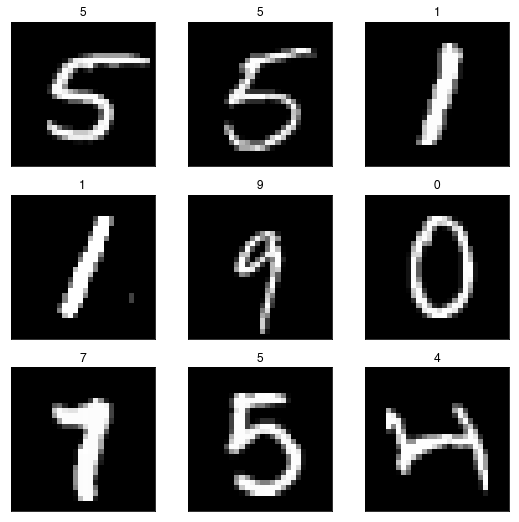

In [14]:
plots(x_trn[:9], y_trn[:9])

For gradient descent to work efficiently it is important that all the input variables or features are roughly on the same order of magnitude. Typically, we try to get them around 1.

In [15]:
def normalize(x): return x / 255

In [16]:
x_trn = normalize(x_trn)
x_val = normalize(x_val)

In [17]:
x_trn[0, 12:15, 12:15]

array([[0.        , 0.        , 0.        ],
       [0.55294118, 0.38039216, 0.38039216],
       [0.99215686, 0.99215686, 0.99215686]])

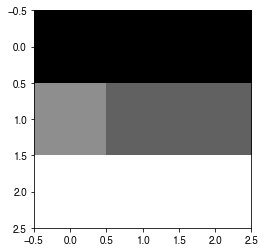

In [18]:
plt.imshow(x_trn[0, 12:15, 12:15], cmap='gray');

Now we will do something pretty dumb. We will flatten out the images and throw away all spatial information.

In [19]:
def flatten(x): return x.reshape(x.shape[0], -1)

In [20]:
x_trn = flatten(x_trn)
x_val = flatten(x_val)

In [21]:
x_trn.shape

(38400, 784)

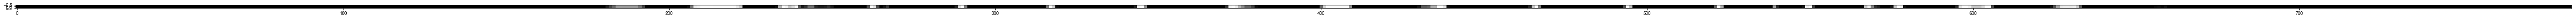

In [22]:
fig = plt.figure(figsize=(100, 1))
plt.imshow(x_trn[0, None, :], cmap='gray');

We are dealing with a classification problem. That means that the correct answer to always one of 10 classes. To pass the numbers to the neural net we one-hot encode the labels.

In [26]:
yoh_trn = to_categorical(y_trn)
yoh_val = to_categorical(y_val)

In [27]:
y_trn[:3], yoh_trn[:3]

(array([5, 5, 1], dtype=uint8),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]))

## Training a simple linear network

To start, let's train a simple linear network.

In [28]:
linear_model = Sequential([
    Dense(10, input_shape=(784,), activation='softmax'),
])

After the matrix multiplication we are using a Softmax layer.

In [29]:
def softmax(x):
    np.exp(x) / np.sum(np.exp(x))

In [30]:
x = [2, 6, 3, 5]

In [31]:
np.exp(x)

array([  7.3890561 , 403.42879349,  20.08553692, 148.4131591 ])

In [32]:
out = np.exp(x) / np.sum(np.exp(x))
out, out.sum()

(array([0.01275478, 0.69638749, 0.03467109, 0.25618664]), 1.0)

Next we need to judge how good our predictions is. For classification we use the categorical crossentropy:

$L = - \sum_c y_t^c \log(y_p^c)$

$c$ is the class, so one of our ten numbers.

In [40]:
linear_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [41]:
linear_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [44]:
linear_model.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 1s 21us/step - loss: 0.3228 - acc: 0.9096 - val_loss: 0.3116 - val_acc: 0.9184
Epoch 2/10
38400/38400 [==============================] - 1s 20us/step - loss: 0.3100 - acc: 0.9130 - val_loss: 0.3031 - val_acc: 0.9214
Epoch 3/10
38400/38400 [==============================] - 1s 21us/step - loss: 0.3014 - acc: 0.9152 - val_loss: 0.2984 - val_acc: 0.9230
Epoch 4/10
38400/38400 [==============================] - 1s 20us/step - loss: 0.2954 - acc: 0.9170 - val_loss: 0.2928 - val_acc: 0.9227
Epoch 5/10
38400/38400 [==============================] - 1s 20us/step - loss: 0.2900 - acc: 0.9186 - val_loss: 0.2900 - val_acc: 0.9237
Epoch 6/10
38400/38400 [==============================] - 1s 19us/step - loss: 0.2857 - acc: 0.9199 - val_loss: 0.2868 - val_acc: 0.9251
Epoch 7/10
38400/38400 [==============================] - 1s 19us/step - loss: 0.2818 - acc: 0.9204 - val_loss: 0.2842 - val_acc:

In [45]:
preds = linear_model.predict(x_val, 4096)

In [46]:
preds[:3]

array([[5.72473909e-05, 2.51993202e-02, 3.86591163e-03, 4.07980680e-02,
        1.33640293e-04, 1.89266484e-02, 1.68624156e-05, 1.60237879e-03,
        8.99161339e-01, 1.02385236e-02],
       [9.22714826e-04, 1.34779536e-03, 7.08749369e-02, 8.78206512e-04,
        2.63856407e-02, 8.39019252e-04, 1.08617544e-01, 1.92984535e-05,
        7.32714891e-01, 5.73999844e-02],
       [1.20204277e-05, 1.65531469e-06, 3.10489937e-04, 2.71605351e-03,
        1.47874453e-04, 2.45547877e-03, 1.88120708e-07, 3.62264514e-01,
        4.30869171e-03, 6.27783000e-01]], dtype=float32)

In [47]:
num_preds = np.argmax(preds, axis=1); num_preds[:3]

array([8, 8, 9])

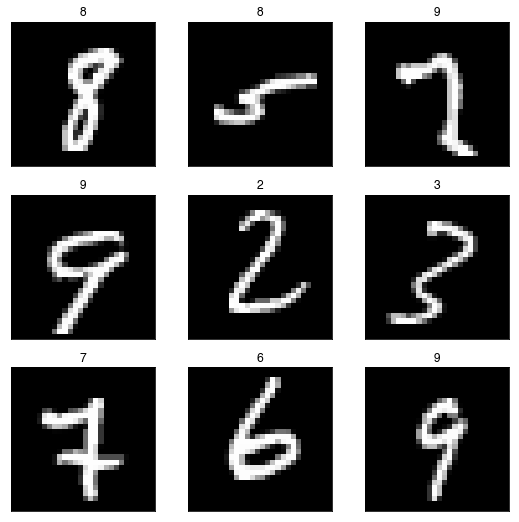

In [48]:
plots(x_val[:9].reshape(-1, 28, 28), num_preds[:9])

## A neural network

A neural network consists of several layers, connected by matrix multiplications. Layers between the input and output layer are called hidden layers. The activations in these layers are passed through a non-linear activation function.

Neural networks can approximate any non-linear function: http://neuralnetworksanddeeplearning.com/chap4.html

In [55]:
neural_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dense(10, activation='softmax'),
])

In [56]:
neural_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [57]:
neural_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [58]:
neural_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 4s 100us/step - loss: 0.5065 - acc: 0.8624 - val_loss: 0.2584 - val_acc: 0.9310
Epoch 2/10
38400/38400 [==============================] - 4s 97us/step - loss: 0.2185 - acc: 0.9384 - val_loss: 0.1901 - val_acc: 0.9484
Epoch 3/10
38400/38400 [==============================] - 4s 92us/step - loss: 0.1616 - acc: 0.9546 - val_loss: 0.1569 - val_acc: 0.9575
Epoch 4/10
38400/38400 [==============================] - 3s 90us/step - loss: 0.1279 - acc: 0.9645 - val_loss: 0.1386 - val_acc: 0.9594
Epoch 5/10
38400/38400 [==============================] - 4s 91us/step - loss: 0.1043 - acc: 0.9712 - val_loss: 0.1196 - val_acc: 0.9654
Epoch 6/10
38400/38400 [==============================] - 3s 88us/step - loss: 0.0860 - acc: 0.9772 - val_loss: 0.1101 - val_acc: 0.9673
Epoch 7/10
38400/38400 [==============================] - 4s 94us/step - loss: 0.0713 - acc: 0.9814 - val_loss: 0.1037 - val_acc

### Deep neural networks

In [59]:
deep_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

In [60]:
deep_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [61]:
deep_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
Total para

In [62]:
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 7s 179us/step - loss: 0.6455 - acc: 0.7998 - val_loss: 0.2005 - val_acc: 0.9428
Epoch 2/10
38400/38400 [==============================] - 6s 166us/step - loss: 0.2149 - acc: 0.9359 - val_loss: 0.1335 - val_acc: 0.9606
Epoch 3/10
38400/38400 [==============================] - 6s 163us/step - loss: 0.1525 - acc: 0.9547 - val_loss: 0.1072 - val_acc: 0.9678
Epoch 4/10
38400/38400 [==============================] - 6s 168us/step - loss: 0.1168 - acc: 0.9640 - val_loss: 0.0955 - val_acc: 0.9716
Epoch 5/10
38400/38400 [==============================] - 7s 172us/step - loss: 0.0951 - acc: 0.9712 - val_loss: 0.0837 - val_acc: 0.9741
Epoch 6/10
38400/38400 [==============================] - 6s 169us/step - loss: 0.0836 - acc: 0.9729 - val_loss: 0.0823 - val_acc: 0.9761
Epoch 7/10
38400/38400 [==============================] - 7s 181us/step - loss: 0.0676 - acc: 0.9788 - val_loss: 0.0819 - v

In [63]:
deep_net.optimizer.lr=1e-4
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 7s 176us/step - loss: 0.0415 - acc: 0.9866 - val_loss: 0.0753 - val_acc: 0.9793
Epoch 2/10
38400/38400 [==============================] - 7s 176us/step - loss: 0.0372 - acc: 0.9877 - val_loss: 0.0784 - val_acc: 0.9797
Epoch 3/10
38400/38400 [==============================] - 7s 175us/step - loss: 0.0344 - acc: 0.9884 - val_loss: 0.0765 - val_acc: 0.9801
Epoch 4/10
38400/38400 [==============================] - 8s 209us/step - loss: 0.0309 - acc: 0.9901 - val_loss: 0.0823 - val_acc: 0.9797
Epoch 5/10
38400/38400 [==============================] - 7s 185us/step - loss: 0.0301 - acc: 0.9896 - val_loss: 0.0784 - val_acc: 0.9798
Epoch 6/10
38400/38400 [==============================] - 6s 168us/step - loss: 0.0309 - acc: 0.9899 - val_loss: 0.0794 - val_acc: 0.9792
Epoch 7/10
38400/38400 [==============================] - 6s 165us/step - loss: 0.0290 - acc: 0.9909 - val_loss: 0.0814 - v

## Convolutions

To take advantage of the spatial information in images we can use convolutions rather than fully connected layers.

http://setosa.io/ev/image-kernels/

In [64]:
conv_net = Sequential([
    Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(10, kernel_size=3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Activation('softmax')
])

In [65]:
conv_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 10)          11530     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 104,714
Trainable params: 104,714
Non-trainable params: 0
_________________________________________________________________


In [66]:
conv_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [67]:
conv_net.fit(x_trn.reshape(-1, 28, 28, 1), yoh_trn, batch_size=512, epochs=10, 
             validation_data=(x_val.reshape(-1, 28, 28, 1), yoh_val))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 27s 700us/step - loss: 0.9417 - acc: 0.7220 - val_loss: 0.3708 - val_acc: 0.8921
Epoch 2/10
38400/38400 [==============================] - 29s 751us/step - loss: 0.3117 - acc: 0.9082 - val_loss: 0.2383 - val_acc: 0.9367
Epoch 3/10
38400/38400 [==============================] - 29s 755us/step - loss: 0.2111 - acc: 0.9371 - val_loss: 0.1735 - val_acc: 0.9467
Epoch 4/10
38400/38400 [==============================] - 35s 901us/step - loss: 0.1521 - acc: 0.9546 - val_loss: 0.1258 - val_acc: 0.9616
Epoch 5/10
38400/38400 [==============================] - 31s 815us/step - loss: 0.1168 - acc: 0.9645 - val_loss: 0.1038 - val_acc: 0.9678
Epoch 6/10
38400/38400 [==============================] - 30s 782us/step - loss: 0.0955 - acc: 0.9714 - val_loss: 0.0849 - val_acc: 0.9749
Epoch 7/10
38400/38400 [==============================] - 31s 816us/step - loss: 0.0806 - acc: 0.9758 - val_loss: 0.0

## End